# Hydrogen Orbitals

**Summary:** The Schrodinger equation for the Hydrogen atom can be solved analytically. The solution results in wavefunctions (the square of which represent the probability of finding an electron at a given location) and associated energy levels. The mathematical derivation of the solution is not presented here, but is easily found in nearly any text on quantum mechanics.

The purpose of the following code is to display the squared wavefunction (probability density), or orbital, given an arbitrary set of quantum numbers (n, l, m).

**Code Implementation:** First, we need to import the modules that we will be using.<br>
> **lpmv:** this will generate the Lagrange polynomials<br>
**math:** defines basic math operations<br>
**cmath:** allows for the use of complex numbers<br>
**const:** creates an object of useful constants<br>
**np:** numerical python: an immense library of numerical functions and data types<br>
**matplotlib/plt:** adds plotting functionality<br>

In [1]:
from scipy.special import lpmv
import math
import cmath
import scipy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

# define some useful constants
a0 = const.physical_constants['Bohr radius'][0]

Given a set of qauntum numbers, we will need to generate a Laguerre polynomial. A Laguerre function is already defined in python in the scipy.special module, however I could not reconcile the output of this function with that tabulated in textbooks. Fortunately, defining a function that evaluates the Laguerre polynomials is not difficult. 

In [2]:
def eval_laguerre(sub, sup, x):
    laguerre_poly = 0
    for i in range(sub + 1):
        laguerre_poly += ((-1) ** i *
                          (math.factorial(sub + sup) ** 2 / (math.factorial(sub - i) * math.factorial(sup + i)))
                          * (x ** i / math.factorial(i)))
    return laguerre_poly

Functions for the radial, aximuthal, and polar wavefunctions are defined:

In [3]:
def radial_wf(n, l, r):
    norm = (math.sqrt(math.factorial(n - l - 1) / (2 * n * math.factorial(n + l) ** 3))
            * (2 / (n * a0)) ** (l + 3 / 2))
    term1 = r ** l * math.exp(-r / (n * a0))
    term2 = eval_laguerre(n - l - 1, 2 * l + 1, 2 * r / (n * a0))
    return norm * term1 * term2


def azimuthal_wf(m, phi):
    return (1 / math.sqrt(2 * math.pi)) * cmath.exp(complex(0, m * phi))


def polar_wf(l, m, theta):
    term1 = (2 * l + 1) / 2
    term2 = math.factorial(l - math.fabs(m)) / math.factorial(l + math.fabs(m))
    norm = math.sqrt(term1 * term2)
    return norm * math.fabs(lpmv(math.fabs(m), l, math.cos(theta)))


def spherical_harmonics(l, m, theta, phi):
    return azimuthal_wf(m, phi) * polar_wf(l, m, theta)

The wavefunction will be multiplied by its conjugate and then integrated over all of space. Here, functions for the square of the wavefunction are defined. This will allow a single function (with the square already taken), as opposed to a function squared, to be passed to a numerical integrator later.

The current formulation of the wavefunction will produce the same wavefunction for quantum numbers $m=\pm\sqrt{m^2}$ (eg; m = 1 and -1). This is because these orbitals have the same energy. Physically, we know that two orbitals of the same energy can exist, and that all orbitals must be orthogonal. Orthogonal sets of orbitals sharing the same quantum number $|m|$ (absolute value of m) are achieved through a linear combination of the +m and -m orbitals. In chemistry, this formulation of the wavefunction is often called the "real representation". Therefore, a function 'wf_angular_real' is defined which creates a linear combination of orbitals of the same energy.

In [4]:
def wf_squared_generator(n, l, m):
    def wf_radial_sqrd(r):
        return radial_wf(n, l, r) ** 2

    def wf_azimuthal_sqrd(phi):
        return (azimuthal_wf(m, phi) * np.conjugate(azimuthal_wf(m, phi))).real

    def wf_polar_sqrd(theta):
        return polar_wf(l, m, theta) ** 2

    def wf_angular_real(phi, theta):
        if m > 0:
            coeff = (1 / math.sqrt(2))
            return (coeff * (spherical_harmonics(l, m, theta, phi) +
                             spherical_harmonics(l, -m, theta, phi))).real ** 2
        elif m < 0:
            coeff = complex(0, -1 / math.sqrt(2))
            pm = math.fabs(m)
            return (coeff * (spherical_harmonics(l, pm, theta, phi) -
                             spherical_harmonics(l, -pm, theta, phi))).real ** 2

        else:
            return (polar_wf(l, m, theta) ** 2) * wf_azimuthal_sqrd(phi)

    return wf_radial_sqrd, wf_azimuthal_sqrd, wf_polar_sqrd, wf_angular_real

Finally, we will want to check to make sure that our wavefunction is normalized. Here we create functions that are multiplied by their appropriate differential area unit.

In [5]:
def wf_integrand_generator(n, l, m):
    def wf_radial_int(r):
        return radial_wf(n, l, r) ** 2 * r ** 2

    def wf_azimuthal_int(phi):
        return (azimuthal_wf(m, phi) * np.conjugate(azimuthal_wf(m, phi))).real

    def wf_polar_int(theta):
        return polar_wf(l, m, theta) ** 2 * math.sin(theta)

    return wf_radial_int, wf_azimuthal_int, wf_polar_int

Now that we have the radial, azimuthal, and polar portions of the wavefunction, we define a function that will check that they are normalized by integrating over all of space: [0, $\infty$) for the radial portion, [0, 2$\pi$] for the azimuthal portion, and [0, $\pi$] for the polar portion. If the wavefunctions are properly normalized, the integral will return 1.

In [6]:
# check normalization
def check_norm(n, l, m):
    def wf_eval_int(lower, upper, func):
        dx = (upper-lower)/1000
        return np.trapz([func(x) for x in np.arange(lower, upper, dx)], dx=dx)

    funcs = wf_integrand_generator(n, l, m)
    para = [(0, 50*a0, 'Radial', funcs[0]), (0, math.pi*2, 'Azimuthal', funcs[1]), (0, math.pi, 'Polar', funcs[2])]
    print('Numerically integrating radial, azimuthal, and polar wavefunctions.')
    print('If they are properly normalized the integral will equal 1.')
    print('-'*50)
    for i in para:
        print('Integral of {} Wavefunction: {}'.format(i[2], wf_eval_int(i[0], i[1], i[3])))

Finally, a funcion that will plot a represention of the (n, l, m) hydrogen orbital is defined.

In [7]:
# make a contour plot
def contour_slice(r_max, n, l, m):
    r_values = np.linspace(0, r_max * a0, 200)
    phi_values = np.radians(np.linspace(0, 360, 100))

    r, phi = np.meshgrid(r_values, phi_values)

    values_xy = np.zeros(np.shape(r))
    values_xz = np.zeros(np.shape(r))
    values_yz = np.zeros(np.shape(r))

    funcs = wf_squared_generator(n, l, m)

    # print(funcs[3](math.pi / 2, math.pi / 2))

    for x, i in enumerate(r_values):
        for y, j in enumerate(phi_values):
            values_xy[y][x] = funcs[0](i) * funcs[3](j, math.pi / 2)
            values_xz[y][x] = funcs[0](i) * funcs[3](0, math.pi / 2 - j)
            values_yz[y][x] = funcs[0](i) * funcs[3](math.pi / 2, math.pi / 2 - j)

    info = list()
    info.append([0, 'xy', values_xy])
    info.append([1, 'xz', values_xz])
    info.append([2, 'yz', values_yz])

    v_max = max([np.max(values_xy), np.max(values_xz), np.max(values_yz)])
    v_min = min([np.min(values_xy), np.min(values_xz), np.min(values_yz)])

    fig, ax = plt.subplots(1, 3, figsize=(10, 20), subplot_kw=dict(projection='polar'))

    for i in info:
        ax[i[0]].set_title('%s Plane' % i[1])
        ax[i[0]].xaxis.set_visible(False)
        ax[i[0]].yaxis.grid(False)
        ax[i[0]].xaxis.grid(False)
        ax[i[0]].spines['polar'].set_visible(False)

        ax[i[0]].contourf(phi, r / a0, i[2], 100, cmap='bone_r', vmin=v_min, vmax=v_max)

        fig.canvas.draw()
        radial_labels = [item.get_text() for item in ax[i[0]].get_yticklabels()]
        radial_labels = ['$' + text + 'a_0$' if c % 2 else '' for c, text in enumerate(radial_labels, 1)]
        ax[i[0]].set_yticklabels(radial_labels)
        ax[i[0]].tick_params(axis='y', colors='red')

    plt.show()


def plot_3d(r_max, n, l, m):
    # use cartesian coordinate system for ease of use
    n_pts = 20
    r_max = r_max * a0
    x = np.linspace(-r_max, r_max, n_pts)
    y = np.linspace(-r_max, r_max, n_pts)
    z = np.linspace(-r_max, r_max, n_pts)

    # convert points to spherical coordinates
    r, phi, theta = [], [], []
    xs, ys, zs = [], [], []
    for i in x:
        for j in y:
            for k in z:
                r.append(math.sqrt(i ** 2 + j ** 2 + k ** 2))
                phi.append(math.atan(j / i))
                theta.append(math.atan(math.sqrt(i ** 2 + j ** 2) / k))
                xs.append(i)
                ys.append(j)
                zs.append(k)

    # get wave function values
    funcs = wf_squared_generator(n, l, m)
    values = []
    for i, j, k in zip(r, phi, theta):
        values.append(funcs[0](i) * funcs[3](j, k))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def normalize(value):
        return (value - min(values)) / (max(values) - min(values))

    rgb = matplotlib.cm.bone(75)

    for i, j, k, v in zip(xs, ys, zs, values):
        ax.scatter(i / a0, j / a0, k / a0, color=rgb, alpha=normalize(v))

    ax.set_xlabel('X ($a_0$)')
    ax.set_ylabel('Y ($a_0$)')
    ax.set_zlabel('Z ($a_0$)')
    ax.set_title('$\Psi_{%d, %d, %d}$' % (n, l, m))

    plt.show()

Now that all of the functions have been defined, we can drive the entire program from here. Alter the 'params' (for parameters) variable to choose which orbital to plot. The first element of params is the x, y, and z limit on the graph and should be given in terms of Bohr's radius ($a_0$). The remaining three elements are the quantum numbers n, l, and m. Recall that we did not set up a function to parse user input, so if an unrealistic orbital is requested (l > n for example) the program will fail. Also, note that the graphing could take 1-2 minutes to run.


**************************************************
Orbital: (n=3, l=2, m=0)
**************************************************

Numerically integrating radial, azimuthal, and polar wavefunctions.
If they are properly normalized the integral will equal 1.
--------------------------------------------------
Integral of Radial Wavefunction: 0.9999999920854823
Integral of Azimuthal Wavefunction: 0.9990000000000003
Integral of Polar Wavefunction: 0.9999835510320522

 Plotting contour slices of orbital. . . 



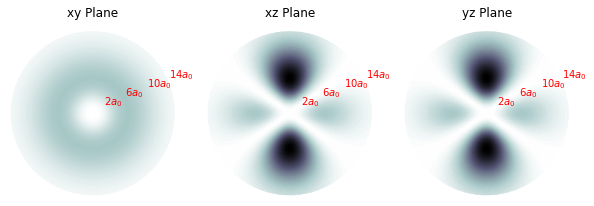


 Plotting 3d representation . . . (make take two minutes)



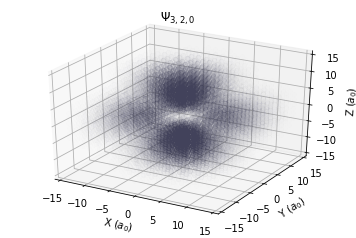

In [8]:
# adjust user input here (radius in terms of Bohr's radius, quantum numbers: n, l, m)
params = (14, 3, 2, 0)

if __name__ == '__main__':
    print('')
    print('*'*50)
    q_str='(n={}, l={}, m={})'.format(*params[1:])
    print('Orbital: {}'.format(q_str))
    print('*'*50)
    print('')
    check_norm(*params[1:])
    print('\n Plotting contour slices of orbital. . . \n')
    contour_slice(*params)
    print('\n Plotting 3d representation . . . (make take two minutes)\n')
    plot_3d(*params)
    